In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import sys
import pyarrow

In [5]:
# retreive stock data
path = '../../data/stock_data_sp500_2016_2018.parquet'
df = pd.read_parquet(path)

#compute daily market price mean(stock_issued * stock_price)
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.date
df['value'] = df.Close * df.Volume
daily = df.groupby('Date').agg({'value': 'sum', 'Volume': 'sum'})
daily['price'] = daily.value / daily.Volume

In [6]:
daily.head()

,value,Volume,price
Date,,,
2016-01-04,1.219584e+11,3.154764e+09,38.658477
2016-01-05,9.884959e+10,2.547937e+09,38.795938
2016-01-06,1.152943e+11,2.986486e+09,38.605324
2016-01-07,1.320685e+11,3.511790e+09,37.607178
2016-01-08,1.117577e+11,3.106335e+09,35.977341


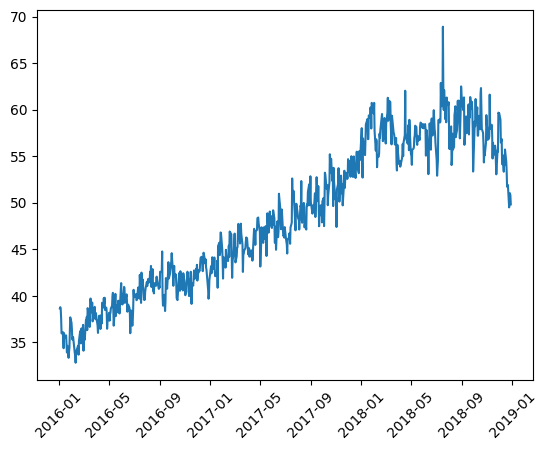

In [33]:
price = daily.price.values
plt.plot(daily.index, price)
plt.xticks(rotation=45)
plt.show()

In [34]:
# train, val, test split
def time_series_split(data, val_size=0.2, test_size=0.2):
    if type(data) != np.ndarray:
        data = np.array(data)
    
    split1 = int(len(data) * (1 - test_size))
    split2 = int(split1 * (1 - val_size))
    train, val, test = np.split(data, [split2, split1])
    
    return train.reshape(-1,1), val.reshape(-1,1), test.reshape(-1,1)

In [35]:
# This setup is for sequence to sequence prediction
# With this setup, forecasting period will be loceked to the same length as the lookback period
# Should discuss whether using this one-step-ahead forecast make sense
def create_dataset(data, lookback):
    n_data, n_feat = data.shape
    X = np.empty((n_data-lookback, lookback, n_feat))
    y = np.empty((n_data-lookback, lookback, n_feat))
    for i in range(n_data-lookback):
        feature = data[i:i+lookback]
        target = data[i+1:i+lookback+1]
        X[i] = feature
        y[i] = target
    return torch.tensor(X), torch.tensor(y)

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, n_nodes, output_dim=1, n_layers=1):
        # input is in format (batch_size, seq_len, num_features)
        super().__init__()
        self.input_dim = input_dim
        self.n_nodes = n_nodes
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        # Define LSTM layer(s)
        self.lstm = nn.LSTM(self.input_dim, self.n_nodes, self.n_layers, bias=True, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(self.n_nodes, output_dim)
        
    def forward(self, x):
        # output is in format (batch_size, seq_len, output_dim)
        out, _ = self.lstm(x)
        pred = self.linear(out)
        return pred

In [37]:
train, val, test = time_series_split(price)
print(train.shape, val.shape, test.shape)

scaler = MinMaxScaler((0,1))
scaler.fit(train)
norm_train = scaler.transform(train)
norm_val = scaler.transform(val)
norm_test = scaler.transform(test)

lookback = 1
X_train, y_train = create_dataset(norm_train, lookback)
X_val, y_val = create_dataset(norm_val, lookback)
X_test, y_test = create_dataset(norm_test, lookback)

print(X_train.shape, y_train.shape)

(481, 1) (121, 1) (151, 1)
torch.Size([480, 1, 1]) torch.Size([480, 1, 1])


In [38]:
model = LSTMModel(input_dim=1, n_nodes=50, output_dim=1, n_layers=4)
model.double()
optimizer = opt.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=10)
n_epochs = 2000

for t in range(n_epochs):    
    model.train()
    
    for feat, label in loader:
        y_pred = model(feat)
        loss = loss_fn(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    if t % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()
        print("Epoch %d: train RMSE %.4f, val RMSE %.4f" % (t, np.sqrt(loss.item()), np.sqrt(val_loss)))

Epoch 0: train RMSE 0.2084, val RMSE 0.5248
Epoch 100: train RMSE 0.0498, val RMSE 0.1545
Epoch 200: train RMSE 0.0546, val RMSE 0.1567
Epoch 300: train RMSE 0.0643, val RMSE 0.1801
Epoch 400: train RMSE 0.0716, val RMSE 0.1971
Epoch 500: train RMSE 0.0541, val RMSE 0.1979
Epoch 600: train RMSE 0.0504, val RMSE 0.1895
Epoch 700: train RMSE 0.0479, val RMSE 0.1656
Epoch 800: train RMSE 0.0619, val RMSE 0.1694
Epoch 900: train RMSE 0.0347, val RMSE 0.1751
Epoch 1000: train RMSE 0.0621, val RMSE 0.1934
Epoch 1100: train RMSE 0.0561, val RMSE 0.1852
Epoch 1200: train RMSE 0.0475, val RMSE 0.1704
Epoch 1300: train RMSE 0.0445, val RMSE 0.1736
Epoch 1400: train RMSE 0.0628, val RMSE 0.1575
Epoch 1500: train RMSE 0.0620, val RMSE 0.1707
Epoch 1600: train RMSE 0.0605, val RMSE 0.1872
Epoch 1700: train RMSE 0.0552, val RMSE 0.1762
Epoch 1800: train RMSE 0.0456, val RMSE 0.1616
Epoch 1900: train RMSE 0.0589, val RMSE 0.1749


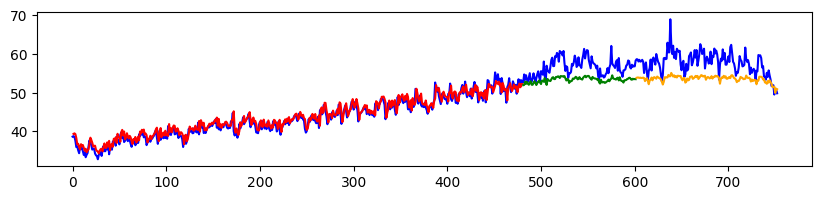

In [39]:
temp_val, _ = create_dataset(scaler.transform(np.concatenate((train[-lookback:], val))), lookback)
temp_test, test_label = create_dataset(scaler.transform(np.concatenate((val[-lookback:], test))), lookback)

model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, 0].view(-1, 1)  # select the 1-D output and reshape from (batch_size, sequence_length) to (batch_size*sequence_length, 1)
    y_pred = scaler.inverse_transform(y_pred)
    train_plot = np.empty_like(price) * np.nan
    train_plot[lookback:len(y_pred)+lookback] = y_pred.flatten()

    val_pred = model(temp_val)
    val_pred = val_pred[:, -1, 0].view(-1, 1)  # select the 1-D output and reshape from (batch_size, sequence_length) to (batch_size*sequence_length, 1)
    val_pred = scaler.inverse_transform(val_pred)
    val_plot = np.empty_like(price) * np.nan
    val_plot[len(y_pred)+lookback:len(y_pred)+len(val_pred)+lookback] = val_pred.flatten()
    
    t_pred = model(temp_test)
    t_pred = t_pred[:, -1, 0].view(-1, 1)  # select the 1-D output and reshape from (batch_size, sequence_length) to (batch_size*sequence_length, 1)
    t_pred = scaler.inverse_transform(t_pred)
    t_plot = np.empty_like(price) * np.nan
    t_plot[len(y_pred)+len(val_pred)+lookback:] = t_pred.flatten()

plt.figure(figsize=(10,2))
plt.plot(price, c='b')
plt.plot(train_plot, c='r')
plt.plot(val_plot, c='g')
plt.plot(t_plot, c='orange')
plt.show()

test RMSE: 52.47977356202435


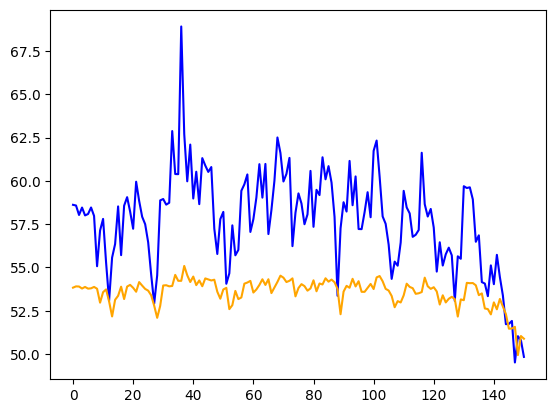

In [42]:
t_loss = np.sqrt(mean_squared_error(t_pred, test_label[:,0,0].view(-1, 1)))
print(f'test RMSE: {t_loss}')
plt.plot(price[len(y_pred)+len(val_pred)+lookback:], c='b')
plt.plot(t_plot[len(y_pred)+len(val_pred)+lookback:], c='orange')
plt.show()

In [7]:
print(torch.__file__)

C:\Users\HP\Anaconda3\lib\site-packages\torch\__init__.py


In [8]:
print(sys.executable)

C:\Users\HP\Anaconda3\python.exe
